# Shape analysis of DAVIS

- DAVIS: Dense Annotated VIdeo Segmentation: https://davischallenge.org/index.html

Khoreva, A., Rohrbach, A. and Schiele, B., 2018. Video object segmentation with language referring expressions. arXiv preprint [arXiv:1803.08006](https://arxiv.org/abs/1803.08006).


Importantly, our method does not only apply to cell morphodynamics. In fact, it is generally applicable to all moving simple (Jordan) polygons.

To illustrate this, we perform unsupervised clustering on the DAVIS dataset (Dense Annotated VIdeo Segmentation ([Khoreva et al. 2018](https://arxiv.org/abs/1803.08006))) to separate video sequences of human movements, animal locomotion and moving vehicles.

We took the annotated masks from the 90 video sequences in the DAVIS 2017 dataset and selected the animated objects that were mostly complete within the field of view and contained little or no occlusion. This resulted in 12 binary videos containing animal movement, 22 with human movement (7 walking, 14 doing sports) and 9 videos with vehicles.

Next, we extracted the contours, created a tensor as described in ... and used tensor decomposition (parafac, rank 3) to embed the videos in a 2D space (using UMAP to project from 3D to 2D space). As the result (Figure ??) shows, this suffices for an accurate clustering per activity group in an unsupervised manner. 





In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob
import numpy as np

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
import cellshapy

Reading config from /home/debacwa/.config/cellshapy


/home/debacwa/Work/cellshapy/cellshapy/config/features.py:23: UserWarning: Package mahotas is missing. Some features are not available


In [2]:
data_folder = '/data/dl-IMAGEDATA/DAVIS/Annotations/480p/**'
fn = '*.png'

In [3]:
from cellshapy.utils import human_sort
import pandas as pd
data_folders = human_sort.sort_human(glob.glob(data_folder))

df = pd.DataFrame( [ {'category': f.split('/')[-1], 
                      'index' : i, 
                      'folder': f} 
                    for i, f in enumerate(data_folders)] )
#display(df)
#[ print( i, f.split('/')[-1]) for i, f in enumerate(data_folders)] 

videos_rgb = {'bear' :         (128,0,0),
              #'bike-packing':  (0,128,0), # too much occlusion
              'blackswan':     (128,0,0),
              #'bmx-bumps':     (0,128,0), # empty frames due to occlusion
              'boxing-fisheye':(128,0,0),
              'breakdance':    (128,0,0),
              'breakdance-flare':(128,0,0),
              'camel':         (128,0,0),
              'car-roundabout':(128,0,0),
              'car-shadow':    (128,0,0),
              'car-turn':      (128,0,0),
              'cows':          (128,0,0),
              'crossing':      (0,128,0), #(128,0,0) also possible 
              'dance-twirl':   (128,0,0),
              #'dancing':       (128,128,0), # contains empty frame AFTER stretching
              'dog':           (128,0,0),
              'dog-gooses':    (128,128,0),
              'dogs-jump':     (0,128,0),
              'drift-chicane': (128,0,0),
              'drift-straight':(128,0,0),
              'drift-turn':    (128,0,0),
              'elephant':      (128,0,0),
              'flamingo':      (128,0,0),
              'goat':          (128,0,0),
              #'gold-fish':     (128,0,0), #only one in class 
              'hike':          (128,0,0),
              'hockey':        None, # None: take all # (128,0,0): human,  (0,128,0): stick
              'horsejump-high':None,
              'horsejump-low': None,
              'judo':          (128,0,0),
              'lab-coat':      (0,0,128),
              'lady-running':  (128,0,0),
              'lindy-hop':     (128,0,0), # (128,128,128) also possible
              #'loading':       (128,0,0), # too much occlusion
              'lucia':         (128,0,0),
              'mallard-fly':   (128,0,0),
              'mallard-water': (128,0,0),
              'miami-surf':    (128,0,0), # probably too small
              'night-race':    (0,128,0),
              'parkour':       (128,0,0),
              'pigs':          (128,0,0),
              #'planes-water':  (128,0,0), # only one in class
              'rallye':        (128,0,0),
              'rhino':         (128,0,0),
              'rollerblade':   (128,0,0),
              #'schoolgirls':   (None, 128, -1), # (128,128,0)+(0,128,0), # -1: must NOT be present, None: may be present
              #'scooter-board': (128,0,0), # empty frames due to occlusion
              'sheep':         (128,0,128),
              'skate-park':    (128,0,0),
              'snowboard':     (0,128,0),
              'stroller':      (128,0,0),
              'stunt':         (0,128,0),
              'tennis':        None,
              'train':         (0,0,128)
             }

classnames = { 0 : 'animal',
            1 : 'person',
            2 : 'sports',
            3 : 'bird',
            4 : 'vehicle'}

videos_class = {'bear' :       0, # animal
              #'bike-packing':  1, # person
              'blackswan':     3, # bird
              #'bmx-bumps':    1,
              'boxing-fisheye':2,
              'breakdance':    2,
              'breakdance-flare':2, 
              'camel':         0,
              'car-roundabout':4, # vehicle
              'car-shadow':    4,
              'car-turn':      4,
              'cows':          0,
              'crossing':      1,
              'dance-twirl':   2, 
              #'dancing':      1, 
              'dog':           0,
              'dog-gooses':    3,
              'dogs-jump':     0,
              'drift-chicane': 4,
              'drift-straight':4,
              'drift-turn':    4,
              'elephant':      0,
              'flamingo':      3,
              'goat':          0,
              #'gold-fish':     4, # fish
              'hike':          1, 
              'hockey':        2, 
              'horsejump-high':0, 
              'horsejump-low': 0, 
              'judo':          2, 
              'lab-coat':      1, 
              'lady-running':  1, 
              'lindy-hop':     2, 
              #'loading':       1, 
              'lucia':         1,
              'mallard-fly':   3,
              'mallard-water': 3, 
              'miami-surf':    2, 
              'night-race':    4,
              'parkour':       2,
              'pigs':          0, 
              #'planes-water':  3,
              'rallye':        4,
              'rhino':         0, 
              'rollerblade':   2, 
              #'schoolgirls':  1,
              #'scooter-board':1,
              'sheep':         0,
              'skate-park':    2,
              'snowboard':     2,
              'stroller':      1,
              'stunt':         2,
              'tennis':        2,
              'train':         4
             }              

# video_indices = [ 0, # bear
#                  #2, # blackswan
#                   8, # breakdance
#                  10, # camel
#                  32, # elephant
#                  34, # goat
#                  38, # horse-high
#                  39, # horse-low
#                  47, # lady running
#                  #49, # lindy-hop (dance)
#                  50, # loading (short: 50)
#                  52, # lucia (walking)
#                  54, # mallard-water (duck)
#                  #56, # miami-surf
#                  63, # parkour
#                  67, # rhino
#                  68, # rollerblade (short: 34)
#                  #75, # skatepark (too small)
#                  76, # snowboard
#                  79, # stroller
#                  80, # stunt
#                  83, # tennis
#                 ]

struct = []
for (key, value), (key2, value2) in zip(videos_rgb.items(), videos_class.items()):
    if key != key2:
        raise ValueError(f'key {key}!= key2 {key2}')
    index = df[df['category'] == key]['index'].values[0]
    folder = df[df['category'] == key]['folder'].values[0]
    itemclass = df[df['category'] == key]['folder'].values[0]
    #df['RGB'] = value
    struct.append( {'folder': folder,
                    'category': key,
                    'index': index,
                    'class':value2,
                    'classname':classnames[value2],
                    'RGB': value})
df = pd.DataFrame(struct)
df.head()

# remove birds
df = df[df['class'] != 3]

df.head()


RGB          category  class classname  \
0  (128, 0, 0)              bear      0    animal   
2  (128, 0, 0)    boxing-fisheye      2    sports   
3  (128, 0, 0)        breakdance      2    sports   
4  (128, 0, 0)  breakdance-flare      2    sports   
5  (128, 0, 0)             camel      0    animal   

                                              folder  index  
0     /data/dl-IMAGEDATA/DAVIS/Annotations/480p/bear      0  
2  /data/dl-IMAGEDATA/DAVIS/Annotations/480p/boxi...      6  
3  /data/dl-IMAGEDATA/DAVIS/Annotations/480p/brea...      7  
4  /data/dl-IMAGEDATA/DAVIS/Annotations/480p/brea...      8  
5    /data/dl-IMAGEDATA/DAVIS/Annotations/480p/camel     10

In [11]:
df = df.drop(['RGB', 'folder'], axis=1)

In [12]:
#annotations = df.to_dict('records')

dest_folder = '/data/debacwa/cellshapy/dataset-DAVIS'
# save annotations
outfilename = os.path.join(dest_folder, 'annotation.csv')
df.to_csv(outfilename)


In [5]:
cl, count = np.unique(df['class'], return_counts=True)
for i, c in enumerate(cl):
    print(f'Class "{classnames[c]}" : count = {count[i]}')


Class "animal" : count = 12
Class "person" : count = 6
Class "sports" : count = 14
Class "vehicle" : count = 9


In [6]:
def img_array_to_single_val(im, rgb):
    '''Create binary mask of image given specific RGB values
    
    Ref: https://stackoverflow.com/a/33196320
    
    Args:
        im (ndarray: HxWx3): image in 8bit RGB format
        rgb (arraylike, length=3): RGB value of foreground
    Returns:
        mask (ndarray: HxW): binary mask
    '''
    
    if rgb is None:
        # if rgb is None: do simple thresholding
        result = (np.mean(im, axis=-1)>0.01).astype(np.uint8) * 255
        return result
    
    # if rgb is specified, select RGB values pixelwise
    result = np.ndarray(shape=im.shape[:2], dtype=np.uint8)
    result[:,:] = 0
    result[(im==rgb).all(axis=-1)] = 255
    return result.astype(np.uint8)

def read(fn, rgb):
    im = io.imread(fn)
    im = transform.resize(im, output_shape=(im.shape[0],im.shape[1]), order=1)
    im = (im*255).astype(np.uint8)
    im = img_array_to_single_val(im, rgb)
    # mean of all channels
    #im = (np.mean(im, axis=-1)>(0.00)).astype(np.uint8)
    # only red
    #im = (im[..., 0]>0).astype(np.uint8)
    im = im.astype(np.uint8)
    #print(im.mean().round(2))
    #plt.imshow(im)
    #plt.show()
    return im

- read images, resize and select masks

In [7]:
vids = []
from cellshapy.config import tqdm
from skimage import io, transform
for i, row in tqdm(df.iterrows(), total=len(df)):
    folder = row['folder']
    rgb = row['RGB']
    print(row['category'])
    fns = human_sort.sort_human(glob.glob(os.path.join(folder, '*.png')))
    ims = np.array([read(fn, rgb) for fn in fns])
    vids.append(ims)
    #print(ims.shape)


bear


/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.


boxing-fisheye
breakdance
breakdance-flare


KeyboardInterrupt: 

- cut all videos to the max/min/mean length of the shortest video

In [ ]:
#trim_length = min([len(v) for v in vids])
#trim_length = max([len(v) for v in vids])
trim_length = int(np.mean([len(v) for v in vids]))

print(f"Trimming videos to length {trim_length}")
from cellshapy.utils.video import equalize_lengths
vids = equalize_lengths(vids, trim_length, n_jobs=1)

In [ ]:
#[f.mean() for f in vids[13]]

- plot a frame for each video

In [ ]:
n = int(np.ceil(np.sqrt(len(vids))))
fig, ax = plt.subplots(n, n, figsize=(25,20), squeeze=False)
fig.tight_layout()
for i, (a,v,cat) in enumerate(zip(ax.flatten(), vids, df['category'])):
    frame = max_length//2
    #frame = 26
    a.imshow(v[frame], cmap='gray')
    a.set_title(cat, fontsize=16)
    a.axis('off')
for a in ax.flatten()[i+1:]: a.set_visible(False)


- export to TIFF (for curation)

In [658]:
from skimage.external import tifffile
for v, (i, row) in zip(vids, df.iterrows()):
    index = row['index']
    classname = row['classname']
    videoname = row['category']
    # WARNING: IF YOU UNCOMMENT THIS, YOU WILL OVERWRITE THE CURATED VIDEOS!!
    outfilename = f'../data/DAVIS-masks/{index:03d}_{videoname}_{classname}.tif'
    print(v.min(), v.max(), v.dtype)
    tifffile.imsave(outfilename, v, compress=6)

0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8
0 255 uint8


- import curated TIFF stacks

In [9]:
from skimage.external import tifffile
from tqdm import tqd_notebook as tqdm

vids_curated = []

for fn in tqdm(human_sort.sort_human(glob.glob('../data/DAVIS-masks/*.tif'))):
    im = tifffile.imread(fn)
#    #print(im.shape)
    vids_curated.append(im)
    

ImportError: cannot import name 'tqdmnotebook'

Import in cellshapy

In [10]:
print( len(annotations), len(vids_curated))


41 41


In [11]:
# set to 100 points
from cellshapy import config
config['contours']['n_points'] = '80'
config['contours']['n_points']

KeyError: 'Category and key name required.'

In [12]:
len(annotations)

41

In [14]:
videos = cellshapy.VideoCollection.from_arrays(vids_curated, annotations=annotations, normalize_distances=True, n_jobs=-1)

Creating VideoCollection from list of 41 arrays. video files or directories


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Iteration 4, error: 0.000006, time: 6.91 sec
2829 contours aligned in 8.66 sec


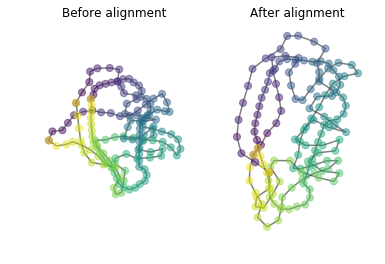

In [15]:
_ = videos.align_contours(show_samples=3, tolerance=1e-5)

In [16]:
#HTML(videos.show(show_image=True, show_contour=False))

In [17]:
#HTML(videos.show(show_image=False, show_contour=True))

- shape analysis

In [18]:
# rotate shapes by 90 degrees
videos.rotate_shapes(degrees=-90)

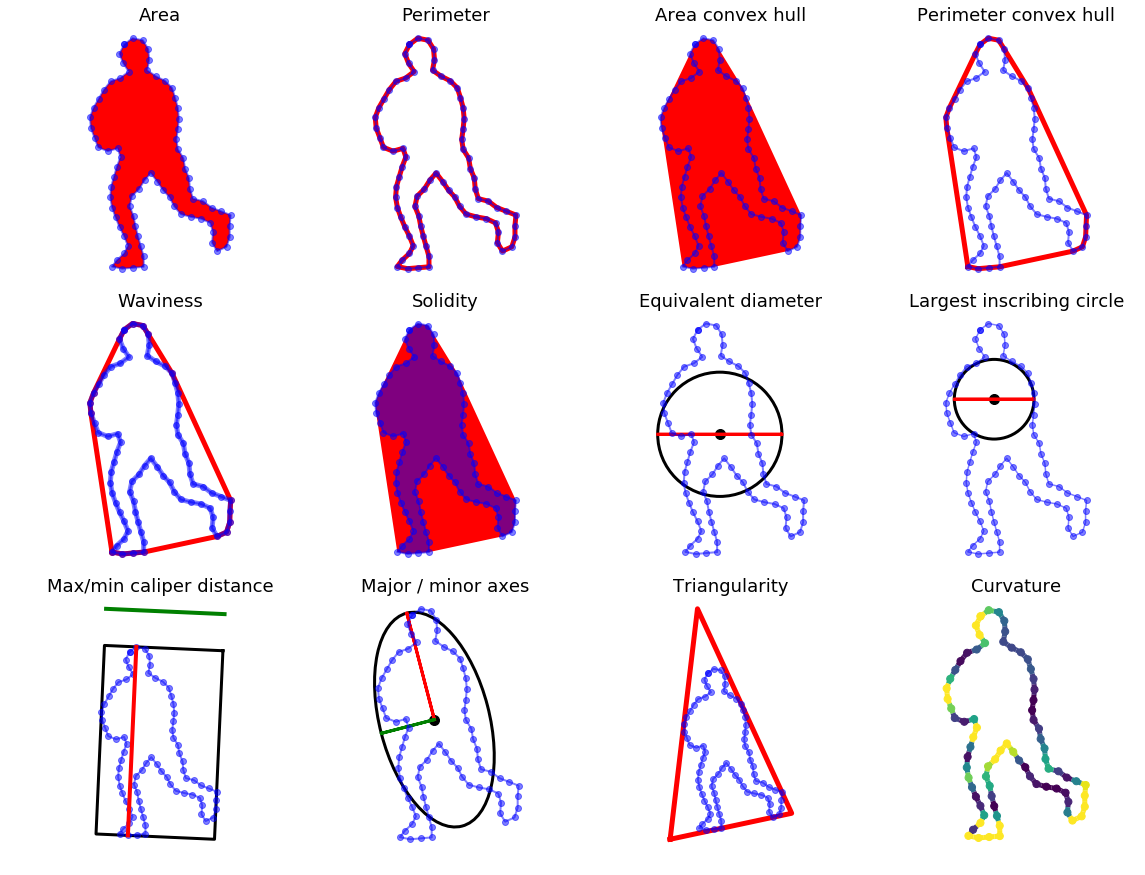

In [676]:
from cellshapy.utils.contours import extract_shape_descriptors
_ = videos[-2][2].extract_shape_descriptors(plot=True, skeleton=False)

In [18]:
videos.embed_shapes(source='all', method='pca', n_components=3)

`pca` embedding for `descriptors`reset `solidity` to mean-subtracted, not standardized
reset `waviness` to mean-subtracted, not standardized
reset `circularity` to mean-subtracted, not standardized
reset `eccentricity` to mean-subtracted, not standardized
 done (0.35 s).
`pca` embedding for `contours` done (0.03 s).


/home/debacwa/Work/cellshapy/cellshapy/plotting/shapespace.py:37: UserWarning: Projecting from 3 components to 2D using pca.


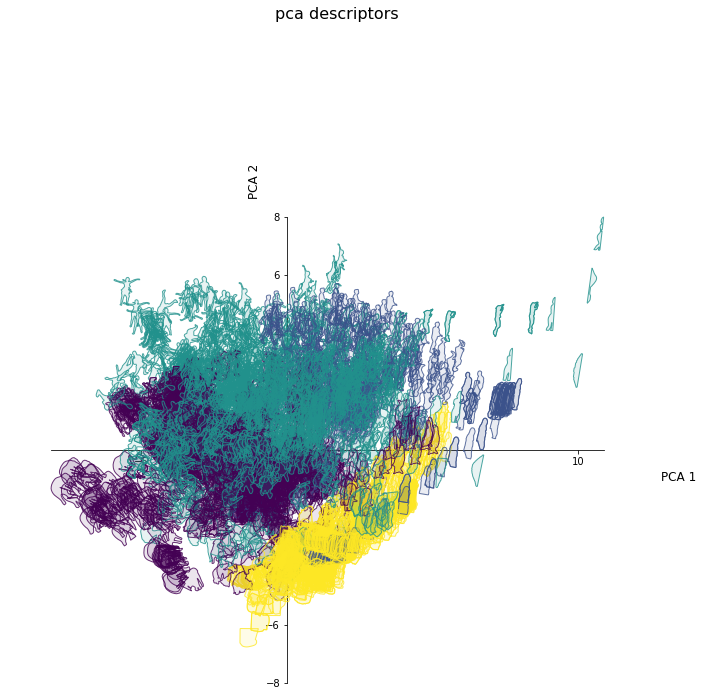

In [19]:
_ = videos.shape_space('descriptors', 'pca', colorcode='class', shape_size=250, components=[1,2],
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.1, alpha_edge=.8)

/home/debacwa/Work/cellshapy/cellshapy/plotting/shapespace.py:37: UserWarning: Projecting from 3 components to 2D using pca.


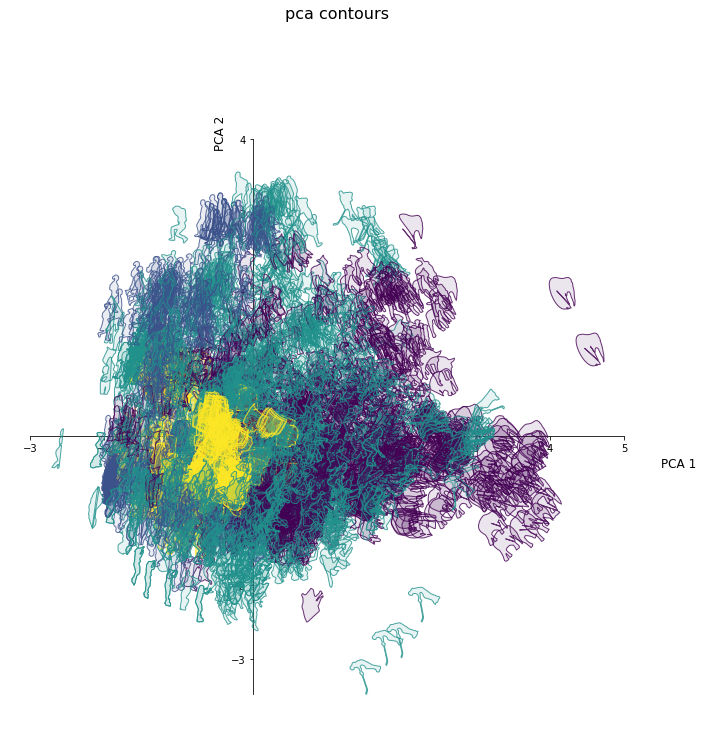

In [20]:
_ = videos.shape_space('contours', 'pca', colorcode='class', shape_size=250, components=[1,2],
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.1, alpha_edge=.8)

In [ ]:
_ = vc.shape_space_polar('contours', 'pca', num_bins=8, shape_size=10)

- morph analysis

`parafac` embedding for `stxy` done (0.40 s).


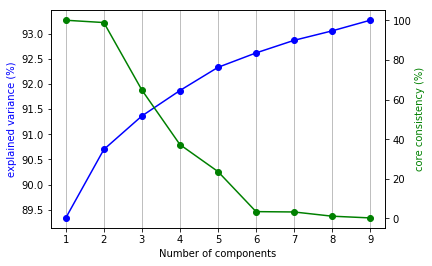

In [698]:
format = 'stxy'
videos.embed_morphs(format, 'parafac', n_components=2, save_embedding=True, plot=False)
df_corcondia, _ = videos.parafac_diagnostics(format, max_components=10)

/home/debacwa/Work/cellshapy/cellshapy/data/videocollection.py:717: UserWarning: VAE is experimental! Limited compatibility.
/home/debacwa/Work/cellshapy/cellshapy/analysis/vae.py:56: UserWarning: Tensor was zero-padded from (41, 69, 96) to (41, 128, 128).


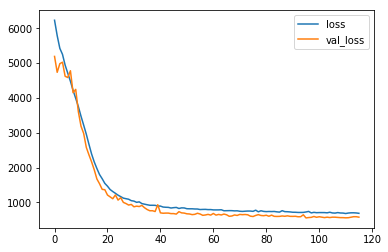

In [43]:
format = 'stxy'
videos.embed_morphs(format, 'vae', n_components=2, plot=False, verbose=False)

components = None


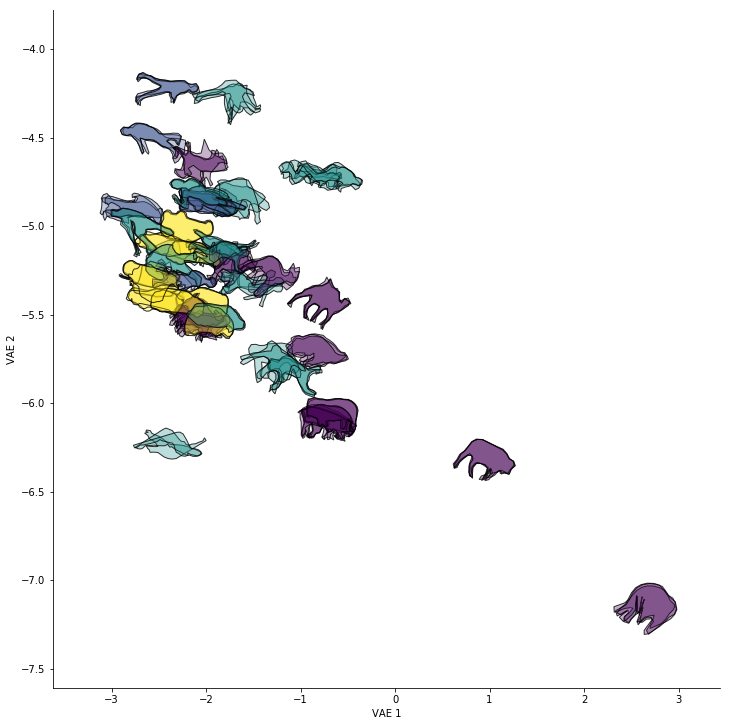

In [44]:
fig = videos.morph_space(format, 'vae', animate=False, frames=[f,f+2,f+4], 
                         shape_size=50, alpha_face=0.3, alpha_edge=0.7, colorcode='class', projection=None)
#fig.savefig('DAVIS.pdf')

num_frames = 69


/home/debacwa/Work/cellshapy/cellshapy/plotting/morphspace.py:375: UserWarning: Projecting from 128 components to 2D using umap.


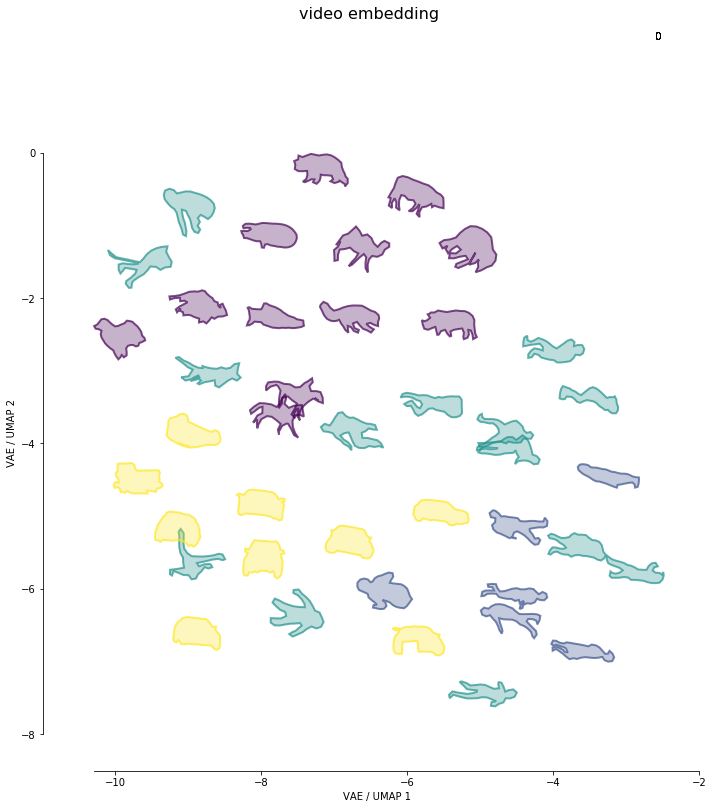

In [25]:
f=40
fig = videos.morph_space(format, 'vae', animate=True, frames=[f,f+2,f+4], 
                         shape_size=50, alpha_face=0.3, alpha_edge=0.7, colorcode='class', projection='umap')

#fig.savefig('DAVIS.pdf')

In [26]:
fig#.save('animals.mp4')

In [592]:
#fig.save('DAVIS.mp4')

In [ ]:
`